In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow_decision_forests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 75.7 MB/s eta 0:00:00


In [ ]:
import numpy as np  # linear algebra
import pandas as pd  #
from datetime import datetime

from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy.stats import yeojohnson

from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

from mlxtend.regressor import StackingCVRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
import tensorflow_decision_forests as tfdf
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('drive/MyDrive/30_Training Dataset_V2/traning_dataset.csv')
# df, dftest = train_test_split(df, test_size=0.2, random_state=42)
dfpred = pd.read_csv('drive/MyDrive/30_Public Dataset_Public Sumission Template_v2/test.csv')

colName = list(df.columns)
colNamepred = list(dfpred.columns)
exColumn = ['ID', '備註', '使用分區']
XColName = list(set(colName) - set(exColumn))
predXColName = list(set(colNamepred) - set(exColumn))

df=df[XColName]
dfpred=dfpred[predXColName]


<Axes: title={'center': 'Log Normal'}, xlabel='單價'>

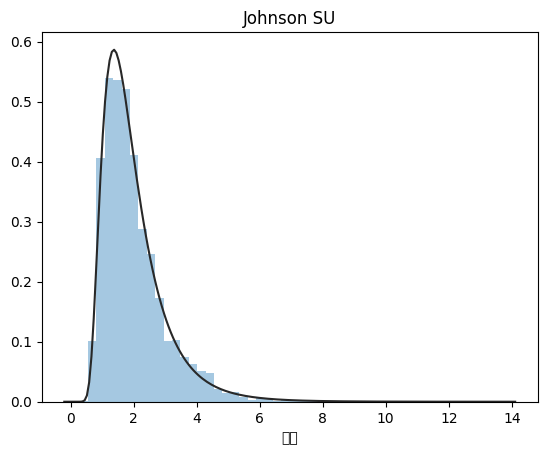

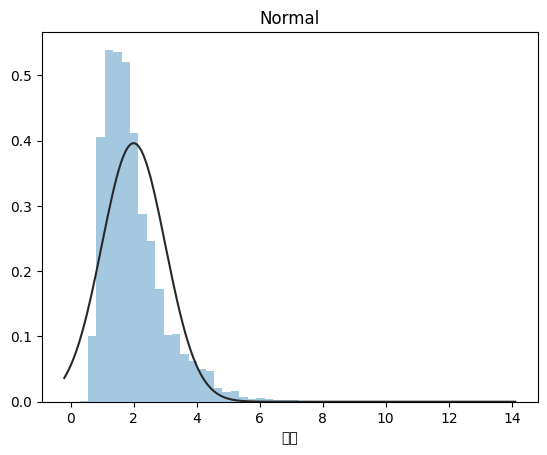

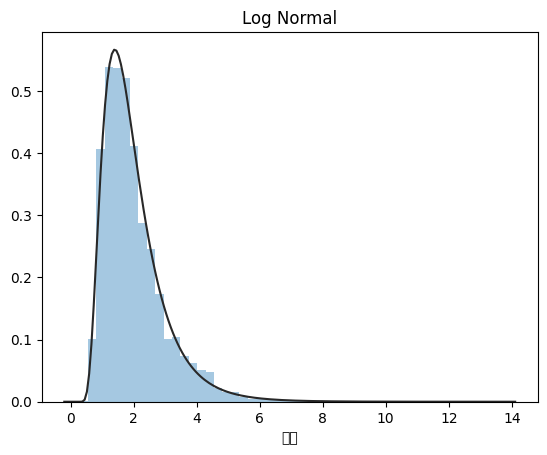

In [ ]:
# y = df['單價']
# plt.figure(1); plt.title('Johnson SU')
# sns.distplot(y, kde=False, fit=stats.johnsonsu)
# plt.figure(2); plt.title('Normal')
# sns.distplot(y, kde=False, fit=stats.norm)
# plt.figure(3); plt.title('Log Normal')
# sns.distplot(y, kde=False, fit=stats.lognorm)

In [ ]:
df["單價"] = np.log1p(df["單價"])
ytrain = df['單價'].sort_index(ascending=True)

In [ ]:
train_features = df.drop(['單價'], axis=1)
pred_features = dfpred

In [ ]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numericstrain = []
for i in train_features.columns:
    if train_features[i].dtype in numeric_dtypes:
        numericstrain.append(i)

numericspred = []
for i in pred_features.columns:
    if pred_features[i].dtype in numeric_dtypes:
        numericspred.append(i)

In [ ]:
skew_features = train_features[numericstrain].apply(lambda x: skew(x))

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
  transformed_data, lambda_value = yeojohnson(train_features[i] + 1)
  train_features[i] = transformed_data


skew_features = pred_features[numericspred].apply(lambda x: skew(x))

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
  transformed_data, lambda_value = yeojohnson(pred_features[i] + 1)
  pred_features[i] = transformed_data

In [ ]:
x_train = train_features.copy()
y_train = ytrain.copy()
x_pred = pred_features.copy()

In [ ]:
df = pd.concat([x_train, y_train], axis=1)

In [ ]:
predictiondf = pd.DataFrame()

In [ ]:
predf = pd.DataFrame()

# **Gradient Boosted Trees**

In [ ]:
train_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(df, label="單價", task = tfdf.keras.Task.REGRESSION)
# 創建一個Boosted Trees回歸模型
model = tfdf.keras.GradientBoostedTreesModel(max_depth=8, task = tfdf.keras.Task.REGRESSION)
model.compile(metrics=["mape"])
# 訓練模型
model.fit(train_dataset)

tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0, max_depth=3)

Use /tmp/tmp4lwcv3x5 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.705085. Found 11751 examples.
Training model...
Model trained in 0:04:14.009755
Compiling model...
Model compiled.


12/12 [==============================] - 1s 60ms/step


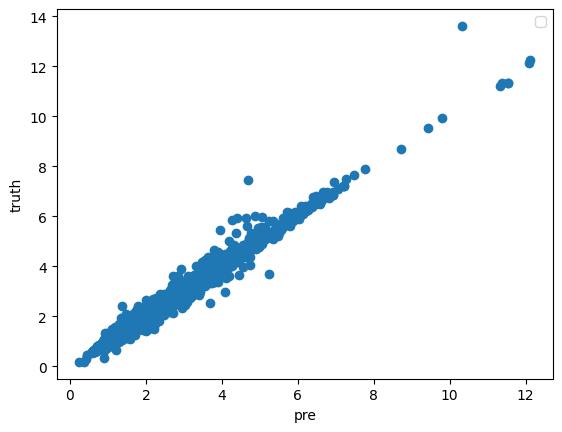

In [ ]:
predictions = model.predict(train_dataset)
predicted_values = [p[0] for p in predictions]
predicted_values = np.expm1(predicted_values)
predictiondf['gbt'] = predicted_values
y = np.expm1(y_train)
plt.xlabel('pre')
plt.ylabel('truth')
plt.scatter(predicted_values ,y.values)

plt.legend()
plt.show()

In [ ]:
SUM=0
for i in range(len(y.values)):
  SUM+=(abs(predicted_values[i]-y.values[i])/y.values[i])
print(SUM/len(predicted_values)*100)

3.5820814414349305


6/6 [==============================] - 0s 43ms/step


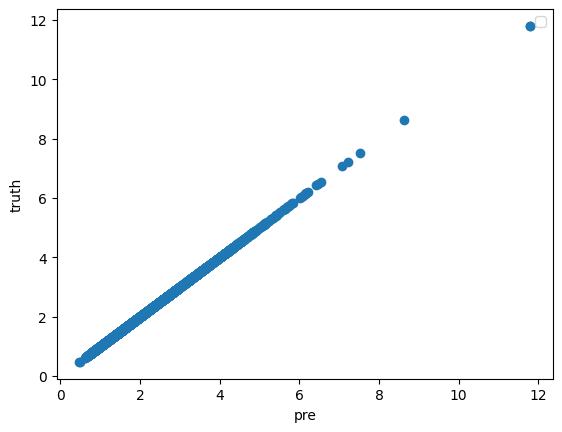

In [ ]:
predict_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(x_pred, task = tfdf.keras.Task.REGRESSION)
predictions = model.predict(predict_dataset)

# 取得預測結果
predicted_values = [p[0] for p in predictions]
predicted_values = np.expm1(predicted_values)
predf['gbt']=predicted_values
plt.xlabel('pre')
plt.ylabel('truth')
plt.scatter(predicted_values ,predicted_values)

plt.legend()
plt.show()

# **Random Forest**

In [ ]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.compile(metrics=["mape"])
rf.fit(train_dataset)
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)


Use /tmp/tmp68c2g3fd as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.454715. Found 11751 examples.
Training model...
Model trained in 0:02:10.481343
Compiling model...
Model compiled.


12/12 [==============================] - 2s 181ms/step


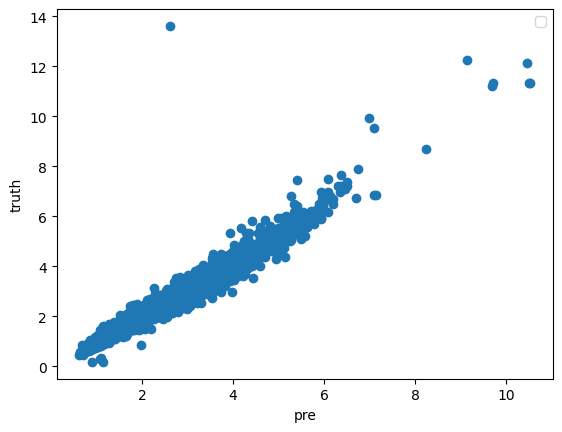

In [ ]:
predictions = rf.predict(train_dataset)
predicted_values = [p[0] for p in predictions]
predicted_values = np.expm1(predicted_values)
predictiondf['rf'] = predicted_values
y = np.expm1(y_train)
plt.xlabel('pre')
plt.ylabel('truth')
plt.scatter(predicted_values ,y.values)

plt.legend()
plt.show()

In [ ]:
SUM=0
for i in range(len(y.values)):
  SUM+=(abs(predicted_values[i]-y.values[i])/y.values[i])
print(SUM/len(predicted_values)*100)

5.594517268542442


6/6 [==============================] - 1s 134ms/step


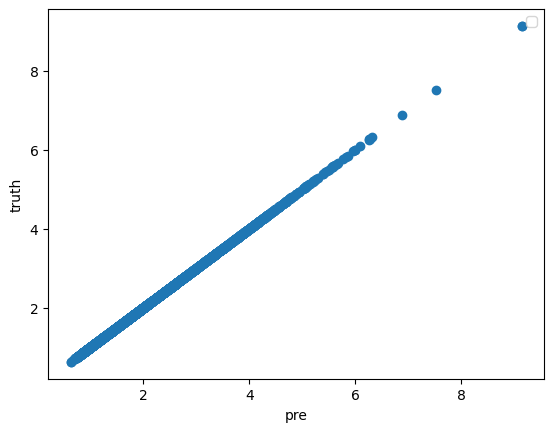

In [ ]:
predictions = rf.predict(predict_dataset)
predicted_values = [p[0] for p in predictions]
predicted_values = np.expm1(predicted_values)
predf['rf']=predicted_values
plt.xlabel('pre')
plt.ylabel('truth')
plt.scatter(predicted_values ,predicted_values)

plt.legend()
plt.show()

# **Cart Model**

In [ ]:
cart = tfdf.keras.CartModel(task = tfdf.keras.Task.REGRESSION)
cart.compile(metrics=["mape"])
cart.fit(train_dataset)
tfdf.model_plotter.plot_model_in_colab(cart, tree_idx=0, max_depth=3)


Use /tmp/tmphpbxcqs7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.466770. Found 11751 examples.
Training model...
Model trained in 0:00:00.636141
Compiling model...
Model compiled.


12/12 [==============================] - 0s 13ms/step


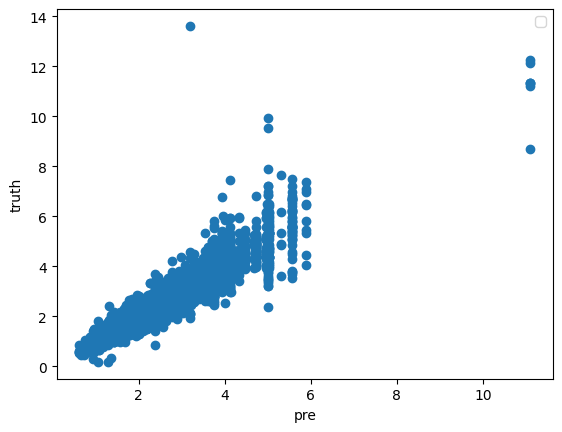

In [ ]:
predictions = cart.predict(train_dataset)
predicted_values = [p[0] for p in predictions]
predicted_values = np.expm1(predicted_values)
predictiondf['cart'] = predicted_values
y = np.expm1(y_train)
plt.xlabel('pre')
plt.ylabel('truth')
plt.scatter(predicted_values ,y.values)

plt.legend()
plt.show()

In [ ]:
SUM=0
for i in range(len(y.values)):
  SUM+=(abs(predicted_values[i]-y.values[i])/y.values[i])
print(SUM/len(predicted_values)*100)

8.952503490158332


6/6 [==============================] - 1s 143ms/step


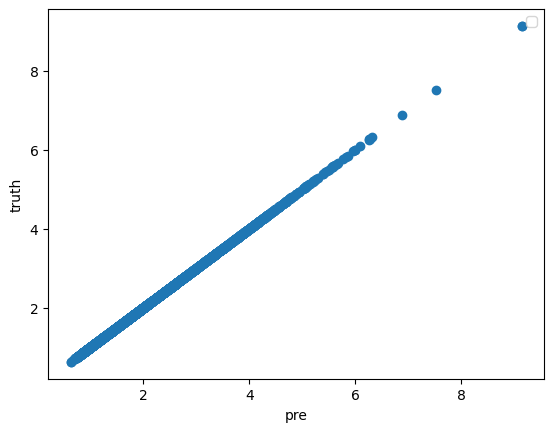

In [ ]:
predictions = rf.predict(predict_dataset)
predicted_values = [p[0] for p in predictions]
predicted_values = np.expm1(predicted_values)
predf['cart']=predicted_values
plt.xlabel('pre')
plt.ylabel('truth')
plt.scatter(predicted_values ,predicted_values)

plt.legend()
plt.show()

# **XGB**

In [ ]:
df = pd.read_csv('drive/MyDrive/30_Training Dataset_V2/traning_dataset.csv')
dfpred = pd.read_csv('drive/MyDrive/30_Public Dataset_Public Sumission Template_v2/test.csv')

colName = list(df.columns)
exColumn = ['ID', '備註', '使用分區','單價']
XColName = list(set(colName) - set(exColumn))

YColName = ['單價']
Y = df[YColName]

dftrain=df[XColName].copy()
dfpre=dfpred[XColName].copy()

XEncoderCol = ['縣市', '主要建材', '建物型態', '主要用途', '路名', '鄉鎮市區']
encoder = LabelEncoder()
for col in XEncoderCol:
  dftrain[col]=encoder.fit_transform(dftrain[col])
  dfpre[col]=encoder.fit_transform(dfpre[col])
x_train, x_test, y_train, y_test = train_test_split(dftrain, Y, test_size=0.2, random_state=42)

In [ ]:
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.02, max_depth=8, booster = 'gbtree')
my_model.fit(dftrain, Y, early_stopping_rounds=5,
             eval_set=[(x_test, y_test)], verbose=False)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
predictions = my_model.predict(dftrain)
predictiondf['xgb'] = predictions
from sklearn.metrics import mean_absolute_percentage_error
print("Mean Absolute Error : " + str(mean_absolute_percentage_error(predictions, Y)*100))

Mean Absolute Error : 3.810410329632567


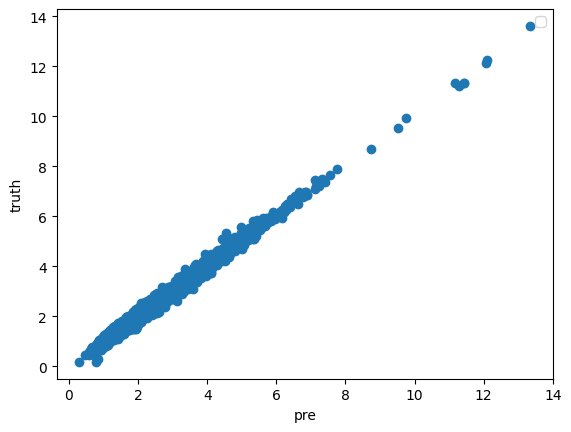

In [ ]:
plt.xlabel('pre')
plt.ylabel('truth')
plt.scatter(predictions ,Y.values)

plt.legend()
plt.show()

In [ ]:
predictions = my_model.predict(dfpre)
predf['xgb'] = predictions

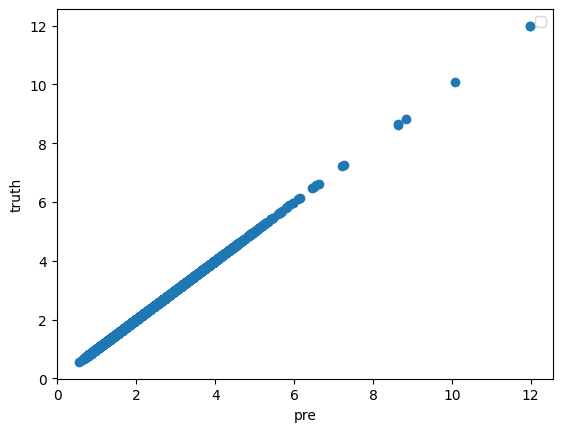

In [ ]:
plt.xlabel('pre')
plt.ylabel('truth')
plt.scatter(predictions, predictions)

plt.legend()
plt.show()

In [ ]:
print(predictiondf)

            gbt        rf      cart       xgb
0      4.631763  4.485785  4.718803  4.452731
1      1.944112  2.183361  2.183095  2.078426
2      1.373730  1.332833  1.296519  1.438701
3      2.202167  2.247781  2.192574  2.196105
4      3.354787  3.477065  3.492235  3.370293
...         ...       ...       ...       ...
11746  0.874171  0.911252  1.078295  0.850432
11747  1.080260  1.075772  0.974406  1.112776
11748  2.022578  2.030933  2.024517  2.061386
11749  2.290623  2.201452  2.205929  2.295020
11750  2.675141  2.637962  2.799997  2.670321

[11751 rows x 4 columns]


In [ ]:
print(predf)

           gbt        rf      cart       xgb
0     1.646786  1.645530  1.645530  1.661424
1     1.677917  1.692389  1.692389  1.644803
2     2.650240  2.724423  2.724423  2.632319
3     1.421371  1.440772  1.440772  1.521548
4     3.538363  3.706731  3.706731  3.540636
...        ...       ...       ...       ...
5871  1.504422  1.493205  1.493205  1.589783
5872  1.615331  1.656389  1.656389  1.662684
5873  2.073569  2.160217  2.160217  2.095366
5874  2.874258  2.965308  2.965308  2.800372
5875  2.166780  2.175926  2.175926  2.190297

[5876 rows x 4 columns]


In [ ]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import mode

tf.random.set_seed(42)

In [ ]:
df = pd.read_csv('drive/MyDrive/30_Training Dataset_V2/traning_dataset.csv')
dfpred = pd.read_csv('drive/MyDrive/30_Public Dataset_Public Sumission Template_v2/test.csv')
# x_train, x_test = train_test_split(df, test_size=0.2, random_state=42)

colName = list(df.columns)
exColumn = ['ID', '備註', '使用分區', '單價', '路名', '鄉鎮市區', '建物型態', '主要用途']
XColName = list(set(colName) - set(exColumn))

YColName = ['單價']
Y = df[YColName]

dftrain=df[XColName].copy()
dfpre=dfpred[XColName].copy()

XEncoderCol = ['縣市', '主要建材']
encoder = LabelEncoder()
for col in XEncoderCol:
  dftrain[col]=encoder.fit_transform(dftrain[col])
  dfpre[col]=encoder.transform(dfpre[col])

In [ ]:
n=4
# IQR = Q3-Q1
for col in dftrain.columns:
  # if '面積' in col:
    high = np.percentile(dftrain[col], 75)
    mid = np.percentile(dftrain[col], 50)
    low = np.percentile(dftrain[col], 25)
    IQR = high - low
    print(col, IQR)
    dftrain[col] = pd.to_numeric(dftrain[col], errors='coerce')
    for i in dftrain[col].values:
      if i < np.percentile(dftrain[col], 25) - n * IQR:
        i = mid
      if i > np.percentile(dftrain[col], 75) + n * IQR:
        i = mid


附屬建物面積 0.5850296509999999
主要建材 0.0
土地面積 1.0564312685
縱坐標 63935.5
陽台面積 1.081815609
主建物面積 1.0082246115
車位個數 1.0
總樓層數 8.0
橫坐標 64541.5
車位面積 1.496914269
建物面積 0.9594788399999999
移轉層次 6.0
屋齡 23.166666667
縣市 10.0


In [ ]:
from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(df, Y, test_size=0.2, random_state=42)
# x_train = dftrain
# y_train = Y
# x_pred = dfpre

x_train = predictiondf
y_train = Y
x_pred = predf
# x_train_normalize = pd.concat([x_train_normalize, predictiondf], axis=1)
# x_pred_normalize = pd.concat([x_pred_normalize, predf], axis=1)

In [ ]:
#preprocess
from sklearn.preprocessing import MinMaxScaler  # 使用 MinMaxScaler object 對 x 做正規化

In [ ]:
#standardscalar training dataset
scaler = MinMaxScaler()
x_train_normalize = scaler.fit_transform(x_train)  # 使用 scaler 將 x 中的特徵 (feature) 其數值變為 0~1 之間的區間
#standardscalar testing dataset
# x_test_normalize = scaler.transform(x_test)
x_pred_normalize = scaler.transform(x_pred)
# x_train_normalize = pd.DataFrame(x_train_normalize)
# x_pred_normalize = pd.DataFrame(x_pred_normalize)

# x_train_normalize = pd.concat([x_train_normalize, predictiondf], axis=1)
# x_pred_normalize = pd.concat([x_pred_normalize, predf], axis=1)

In [ ]:
# print("X SHAPE: ", x_train_normalize.shape, x_test_normalize.shape)
# print("Y SHAPE: ", y_train.shape, y_test.shape)


In [ ]:
#add layers
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=x_train_normalize.shape[1]),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=8, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_46 (Dense)            (None, 16)                80        
                                                                 
 dense_47 (Dense)            (None, 8)                 136       
                                                                 
 dense_48 (Dense)            (None, 1)                 9         
                                                                 
Total params: 225 (900.00 Byte)
Trainable params: 225 (900.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from datetime import datetime
#save dir
SAVE_DIR = 'results'
tag = 'inlier'

file_dir = '{model_name}/model_{tag}'

In [ ]:
# 可更改參數
#model參數設定
model_config = {
    'batch_size': 128,
    'epochs': 200,
    'validation_split': 0.2,
    'callbacks': [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0,
            patience=20,
            verbose=1,
            mode='auto'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=5,
            verbose=1,
            mode='auto'
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(file_dir.format(save_dir=SAVE_DIR, model_name='NN', tag=tag), 'model'),
            monitor='val_loss',
            verbose=0,
            save_best_only=True,
            save_freq='epoch'
        )
    ]
}

In [ ]:
my_adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,)
model.compile(
    optimizer=my_adam,  # 更改 optimizer
    loss=tf.keras.losses.MeanAbsolutePercentageError(),
    metrics=['accuracy']
)

In [ ]:
# train the model
history = model.fit(x_train_normalize, y_train, **model_config)

Epoch 1/200
74/74 [==============================] - 2s 13ms/step - loss: 96.5558 - accuracy: 0.0000e+00 - val_loss: 91.0233 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/200
74/74 [==============================] - 1s 10ms/step - loss: 82.7153 - accuracy: 0.0000e+00 - val_loss: 70.7147 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/200
74/74 [==============================] - 1s 10ms/step - loss: 52.2978 - accuracy: 0.0000e+00 - val_loss: 30.2777 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/200
74/74 [==============================] - 1s 10ms/step - loss: 22.9957 - accuracy: 0.0000e+00 - val_loss: 20.4970 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/200
74/74 [==============================] - 1s 10ms/step - loss: 19.4064 - accuracy: 0.0000e+00 - val_loss: 18.3378 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/200
74/74 [==============================] - 1s 11ms/step - loss: 16.8804 - accuracy: 0.0000e+00 - val_loss: 15.0429 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 7/20

74/74 [==============================] - 0s 2ms/step


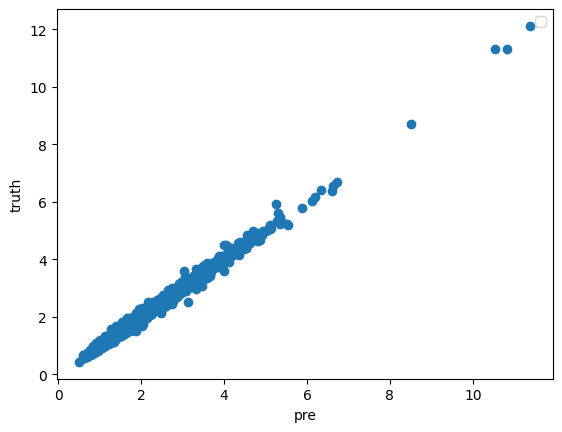

In [ ]:
pre=model.predict(x_test_normalize)

plt.xlabel('pre')
plt.ylabel('truth')
plt.scatter(pre ,y_test)

plt.legend()
plt.show()

In [ ]:
SUM=0
for i in range(len(pre)):
  SUM+=(abs(pre[i]-y_test.values[i])/y_test.values[i])
print(SUM/len(pre)*100)

IndexError: ignored

184/184 [==============================] - 0s 1ms/step


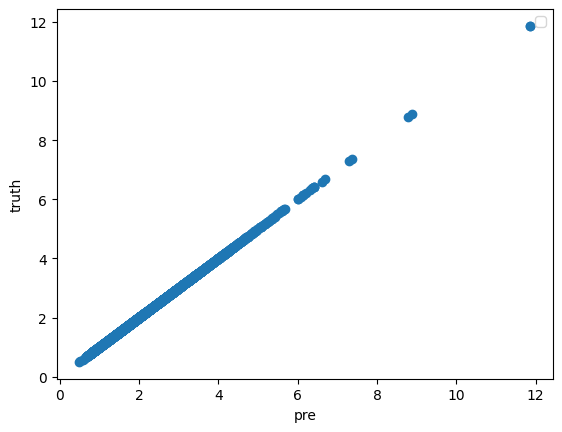

In [ ]:
pre=model.predict(x_pred_normalize)

plt.xlabel('pre')
plt.ylabel('truth')
plt.scatter(pre ,pre)

plt.legend()
plt.show()


In [ ]:
import csv
with open('output.csv', 'w', newline='') as csvfile:
  writer = csv.writer(csvfile)
  writer.writerow(["ID", "predicted_price"])
  for i, value in enumerate(pre):
    writer.writerow([f'PU-{i+1}', value[0]])